# Problem Statement

## How is RSGS affected by existing geosynchrouns satellites and debris?

### Motivation

1. Critical component for mission management and architecture.
2. Regulatory entities have strong concerns about collision, but miss risks of servicing vehicles.
3. Inspired by Draper's work on RPO.
4. Personal interest in orbital mechanics and analysis.

3 Geo sats with 0.2 deg longitude separation (~150km), various inclinations. 
![SegmentLocal](geo3.png "segment")

Notional RPO maneuvers. Consider first burn at ~100km away from target.
![SegmentLocal](rpo.png "segment")
*credit: Ian T Mitchell, Draper Laboratory Overview of Rendezvous and Capture Operations, sspd.gsfc.nasa.gov, 2010, without permission*

## Plan to Solve Problem

### Visualize objects in a region of interest

* Pull TLE files from *spacetrack.org*
* Transform the TLE data into useful coordinate system (lat/lon)
* Build a notional RSGS trajectory
* Determine threats i.e. range from object to RSGS
* Improvements; Build into model

![SegmentLocal](flow.png "segment")

In [1]:
import sys
import pickle
import numpy as nmp
import coord_trans

from tqdm import tqdm
from satellite import Satellite
from satellite import RSGS
from graph import GraphFrame
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

Input Parameters

In [2]:
days = 2                      # Days to run sim
hours = 12                    # Hours to run sim
lon0 = -71                    # RSGS Longitude start (Boston)
target_name = 'GOES 1 '       # Target name (San Francisco)

Load TLE file locally (normally done live via spacetrack.org)

In [3]:
with open('tle/geo.tle', 'rb') as f:
    tle_list = pickle.load(f)

Calculate TLE orbits for all tracked satellites.

In [4]:
epoch1 = datetime.utcnow()
epoch2 = epoch1 + timedelta(days,0,0,0,0,hours)

sat_list = [Satellite(epoch1, epoch2) for n in range(0, len(tle_list), 3)]

for n, sat in enumerate(tqdm(sat_list, desc='Loading Satellites')):
    tle = tle_list[n*3:n*3+3]
    sat.load_tle(tle)

    if target_name in sat.name:
        sat.type = 'target'
        sat_target = sat

Loading Satellites: 100%|██████████| 1354/1354 [00:02<00:00, 498.79it/s]


Parse out only objects in region between Start Lon. and Target Longitude.

In [5]:
lon2 = sat_target.lon[0]
lon0 = lon0 - nmp.sign(lon0)*2
lon2 = lon2 - nmp.sign(lon2)*2

tmp_list = []
for n, sat in enumerate(sat_list):
    lon1 = sat.lon[0]

    if (lon1 >= lon0 and lon1 <= lon2 and lon2 > lon0) \
    or (lon1 <= lon0 and lon1 >= lon2 and lon2 < lon0):
        tmp_list.append(sat)

sat_list = tmp_list

Build RSGS Orbit

In [6]:
rsgs = RSGS(epoch1, epoch2)
rsgs.set_params(-110, lon2)

Calculate motion for all epochs

In [7]:
for n, sat in enumerate(tqdm(sat_list, desc='Computing Motion')):
    sat.get_motion()
    sat.get_range(rsgs)

Computing Motion: 100%|██████████| 206/206 [00:01<00:00, 184.92it/s]


Calculate frames for 3D animation

In [8]:
sat_list.append(rsgs)
frame_cnt = sat_list[0].sim_cnt
frame_list = [GraphFrame(sat_list) for n in range(frame_cnt)]

for n, frame in enumerate(tqdm(frame_list, desc='Building Frames')):
    frame.load_data(n)

Building Frames: 100%|██████████| 2/2 [00:00<00:00, 261.08it/s]


Sidereal Time Equations
![SegmentLocal](nga.png "segment")
*NIMA Technical Reqort TR8350.2, "Department of Defense World Geodetic System 1984, Its Definition and Relationships With Local Geodetic Systems", 2000*

In [9]:
class Graph():
    
    def __init__(self, frame_list, lon0, lon2, epoch1):
        self.frame_list = frame_list
        self.lon0 = lon0
        self.lon2 = lon2
        self.epoch1 = epoch1
        self.fig, self.ax, self.txt = self._setup_fig()
        self.frame_cnt = len(self.frame_list)

    def _setup_fig(self):
        gs = grs.GridSpec(1, 2, width_ratios=[4,1])
        fig = plt.figure(figsize=(14,12), dpi=120)
        #fig.set_size_inches(14, 10, True)
        ax = fig.add_subplot(gs[0], projection='3d')
        ax2 = fig.add_subplot(gs[1])
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        plt.subplots_adjust(wspace=0.00001)
        #plt.rcParams['figure.figsize'] = [14,12]
        plt.rcParams['figure.dpi'] = 200
        return fig, ax, ax2

    def run(self):
        ani = animation.FuncAnimation(
                fig=self.fig,
                init_func=self._init_graph,
                func=self._update_graph,
                frames=self.frame_cnt,
                interval=200)
        return ani
        
    def _init_graph(self):
        self.ax.set_xlabel('Latitude, $\circ$E')
        self.ax.set_ylabel('Longitude, $\circ$E')
        self.ax.set_zlabel('Altitude, km')
        self.ax.set_xlim3d(-15,15)
        self.ax.set_zlim3d(35600,36100)
        if self.lon2 > self.lon0:
            self.ax.set_ylim3d(self.lon0-2, self.lon2+2)
        else:
            self.ax.set_ylim3d(self.lon0+2, self.lon2-2)
        self.txt.grid(False)
        self.txt.set_xticks([])
        self.txt.set_yticks([])

    def _update_graph(self, f):
        frame = self.frame_list[f]

        self.ax.clear()
        self.txt.clear()
        self._init_graph()

        self._update_sats(frame)
        self._update_text(frame)

    def _update_sats(self, frame):
        for n in range(len(frame.lon)):
            x, y, z, s, c, m, name = frame.get_params(n)

            center = (self.lon2+self.lon0)/2
            self.ax.scatter(x, y, z, s=s, c=c, marker=m)
            self.ax.text(x, y, z+10, '%s'%(name), size=5, zorder=1)

    def _update_text(self, frame):
        self.txt.text(0.0,0.92,'Epoch Start:', size=9)
        self.txt.text(0.1,0.90,'%s'%(self.epoch1), size=9)
        self.txt.text(0.0,0.87,'Mission Time:', size=9)
        self.txt.text(0.1,0.85,'%.2f hr'%(frame.mission_time), size=9)
        self.txt.text(0.0,0.82,'RSGS Longitude:', size=9)
        self.txt.text(0.1,0.8,'%.2f $\circ$E'%(frame.lon[-1]), size=9)
        self.txt.text(0.0,0.75,'Range to Object, km:', size=9)

        for n, r in enumerate(frame.range[0:10]):
            name = frame.name_sorted[n]
            color = frame.range_color[n]
            self.txt.text(0.1, 0.73-n*0.015,'%.2f'%(r), size=9, color=color)
            self.txt.text(0.4, 0.73-n*0.015,'%s'%(name), size=9, color=color)

Print Results and Graph

* Show all objects between $71\circ$ and $122\circ$ West at Geo-altitude (~35,800km).
* Animate motion for 13.5 days as RSGS moves from start to end locations.
* Calculate range to objects near RSGS during motion.

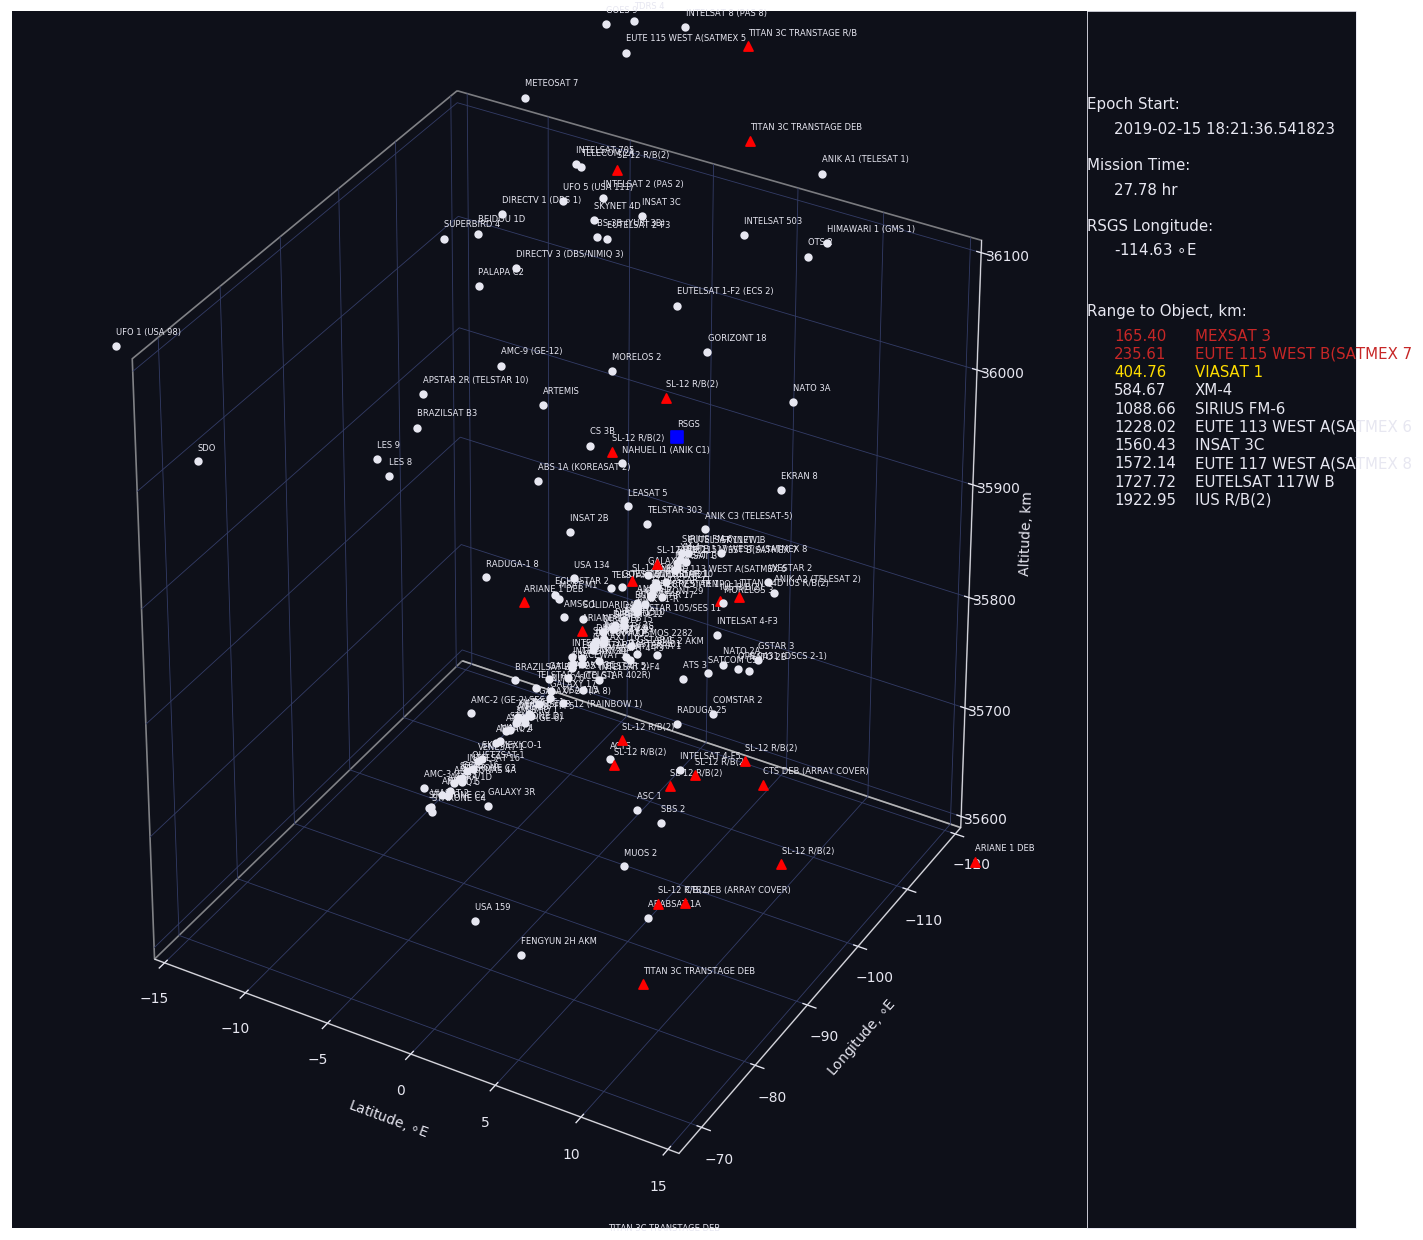

In [10]:
grf = Graph(frame_list, lon0, lon2, epoch1)
ani = grf.run()
HTML(ani.to_html5_video())


## Ideas for the Future

* Tie-in with SysML models
* Conduct true orbital analysis and trajectory planning
 * This is not something that traditional Geo-Comm-Sat orbits people do.

Cortex: "A new framework to develop object-oriented and executable SysML models using the IPython Notebook"
![SegmentLocal](cortex_small.png "segment")
*An Object-oriented and Executable SysML Framework for Rapid Model Development
Santiago Balestrini-Robinson, Dane F. Freeman, Daniel C. Browne  2015*

OpenMDAO: "An Open-source framework for efficient Multidisciplinary Design, Analysis, & Optimization"
![SegmentLocal](mdao.png "segment")
*J. S. Gray, J. T. Hwang, J. R. R. A. Martins, K. T. Moore, and B. A. Naylor, “OpenMDAO: An Open-Source Framework for Multidisciplinary Design, Analysis, and Optimization,” Structural and Multidisciplinary Optimization, 2019.*